# HAPPINESS
___

STAT 201 - Group 12: Anne Nguyen, Eric Pien, Oliver Gullery, Ruby Yang




## Introduction
___

Happiness, a subjective assessment of an individual’s emotional state/life satisfaction, can be affected by factors such as health and social network. As such, happiness can often act as an indicator for societal well-being (1). This report investigates how the COVID-19 pandemic has affected the happiness of the world population. Ultimately, we hope to answer the question: **Did Covid-19 negatively impact levels of happiness**?

We use data from the  *World Happiness Report* (2) where happiness scores are assessed using the Cantril ladder – a  subjective measure for wellbeing. Scores range from 0 to 10, representing the worst and best possible life respectively. We will compare the `mean` and `standard deviation` in happiness score for years before and after the COVID-19 pandemic to examine overall changes in world happiness.  

## Methods & Results ##
___

### Data Loading, Cleaning, Splitting ###

In [8]:
# Environment Setup
install.packages('janitor')
library(tidyverse)
library(tidymodels)
library(GGally)
library(gridExtra)
library(janitor)
library(cowplot)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows


The downloaded binary packages are in
	/var/folders/nf/vpnq0vx13sx43k2_8wh8tw2m0000gn/T//RtmpeVonSR/downloaded_packages


-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.3.6      v purrr   0.3.4 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
-- Attaching packages -------------------------------------- tidymodels 1.0.0 --

v broom        1.0.1     v rsample      1.1.0
v dials        1.0.0     v tune         1.0.1
v infer        1.0.3     v workflows    1.1.0
v modeldata    1.0.1     v workflowsets 1.0.0
v parsnip      1.0.2     v yardstick    1.1.0
v recipes      1.0.1     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filter()   masks stats::filter()
x recipes::fixed()  masks stringr::fixed()
x dplyr::lag()      masks stats::lag()
x yardstick::spec() ma

In [9]:
# Read data from the web into R
data <- read_csv('https://raw.githubusercontent.com/ericpien/stat-201-project/main/data/DataForTable2.1.csv',skip=0)

# Clean/Wrangle Data
happiness_data <- data |>
    clean_names() |>
    as_tibble() |>
    drop_na()

# Create n_tile clusters by the year
n_tile <- 4

happiness_data <- happiness_data |>
    group_by(year) |>
    mutate(life_ladder_ntile = ntile(-life_ladder,n_tile),
            log_gdp_per_capita_ntile = ntile(-log_gdp_per_capita,n_tile),
            social_support_ntile = ntile(-social_support,n_tile),
            healthy_life_expectancy_at_birth_ntile = ntile(-healthy_life_expectancy_at_birth,n_tile),
            freedom_to_make_life_choices_ntile = ntile(-freedom_to_make_life_choices,n_tile),
            generosity_ntile = ntile(-generosity,n_tile),
            perceptions_of_corruption_ntile = ntile(-perceptions_of_corruption,n_tile),
            positive_affect_ntile = ntile(-positive_affect,n_tile),
            negative_affect_ntile = ntile(-negative_affect,n_tile),
            confidence_in_national_government_ntile = ntile(-confidence_in_national_government,n_tile))

# Create wide dataframe of mean happiness
happiness_data_wide_life_ladder <- happiness_data |> 
    group_by(country_name,year) |>
    summarize(life_ladder = life_ladder) |>
    pivot_wider(names_from = year,
                values_from = life_ladder)

Rows: 2089 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (1): Country name
dbl (11): year, Life Ladder, Log GDP per capita, Social support, Healthy lif...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00FC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DF>' to native encoding"


### Preliminary Data Exploration ###

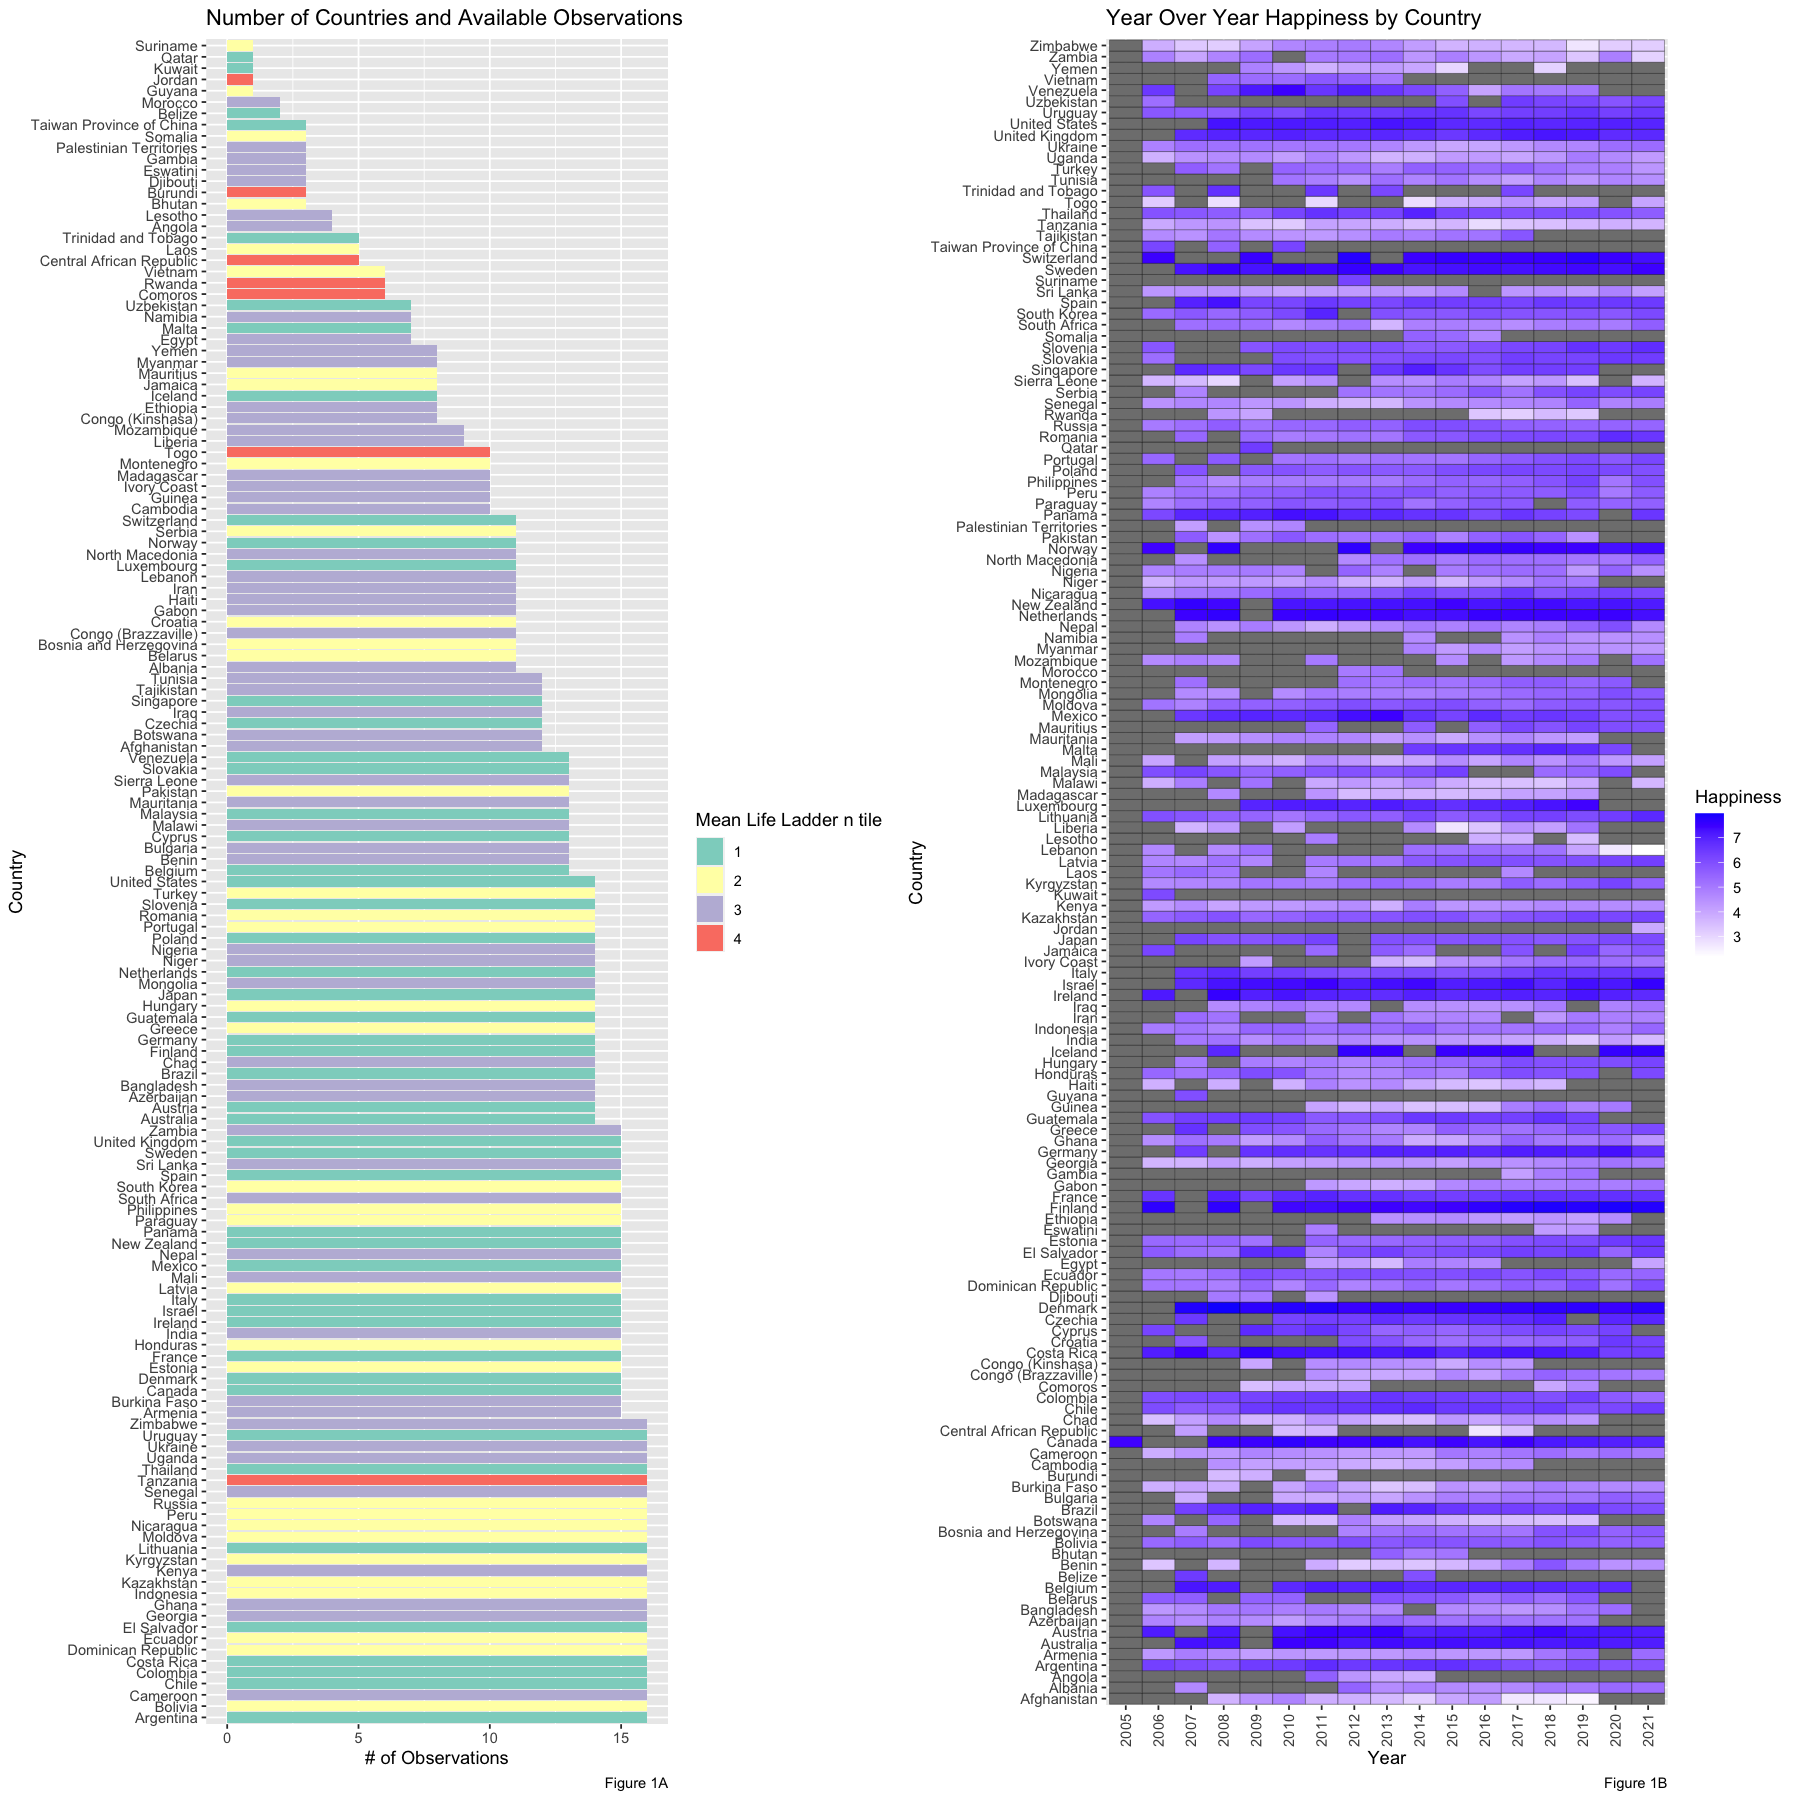

In [10]:
# Number of countries and available data
options(repr.plot.width = 15, repr.plot.height = 15) 

happiness_data_obs <- happiness_data |> 
    group_by(country_name) |> 
    summarize(obs_count=n(),
                mean_cluster = as.integer(mean(life_ladder_ntile))) |>
    arrange(-obs_count) |>
    ggplot(aes(x=obs_count,y=fct_inorder(country_name),fill = factor(mean_cluster))) +
    geom_col() +
    scale_fill_brewer(palette="Set3") +
    labs(x="# of Observations", y="Country", fill="Mean Life Ladder n tile", title="Number of Countries and Available Observations", caption = "Figure 1A")

#happiness_data_obs # Chart displayed as a group below

# YoY happiness metric heatmap
happiness_heatmap <- happiness_data_wide_life_ladder |>
    pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |>
    ggplot(aes(x=year, y=country_name)) +
    geom_tile(aes(fill=life_ladder), color="black") +
    scale_fill_gradient(low="white", high="#1818ff") +
    labs(x="Year", y="Country", fill="Happiness", title="Year Over Year Happiness by Country", caption = "Figure 1B", las = 2) +
    theme(axis.text.x = element_text(angle=90, vjust=.5, hjust=1))

#happiness_heatmap # Chart displayed as a group below
plot_grid(happiness_data_obs,happiness_heatmap,ncol = 2)

Figure 1. A) Plot of the number of observations where happiness score is available from each country in the data set. Countries were also splitted into quartiles based on different factors.  B) Heat map of happiness score for each country from 2005-2021.

### Data Selection ###

In [11]:
# Create a list of countries that have data for 2019 and 2021
country_name_2019_2021  <- happiness_data |>
    group_by(country_name) |>
    filter(year %in% c(2019,2021)) |>
    drop_na() |>
    summarise(n=n()) |>
    filter(n>1) |>
    pull(country_name)

# Select the countries and filter for 2019 and 2021 data
happiness_data_2019_2021 <- happiness_data |>
    filter(country_name %in% country_name_2019_2021,
            year %in% c(2019,2021))

# Summarize the estimates of the parameters (mean and sd) across the groups (2019 and 2021)
happiness_data_2019_2021 |> group_by(year) |> summarise(mean_happiness = mean(life_ladder), sd = sd(life_ladder))



year,mean_happiness,sd
<dbl>,<dbl>,<dbl>
2019,5.737087,1.089441
2021,5.670313,1.138531


Table 1. Summary statistics for happiness scores in 2019 and 2021.

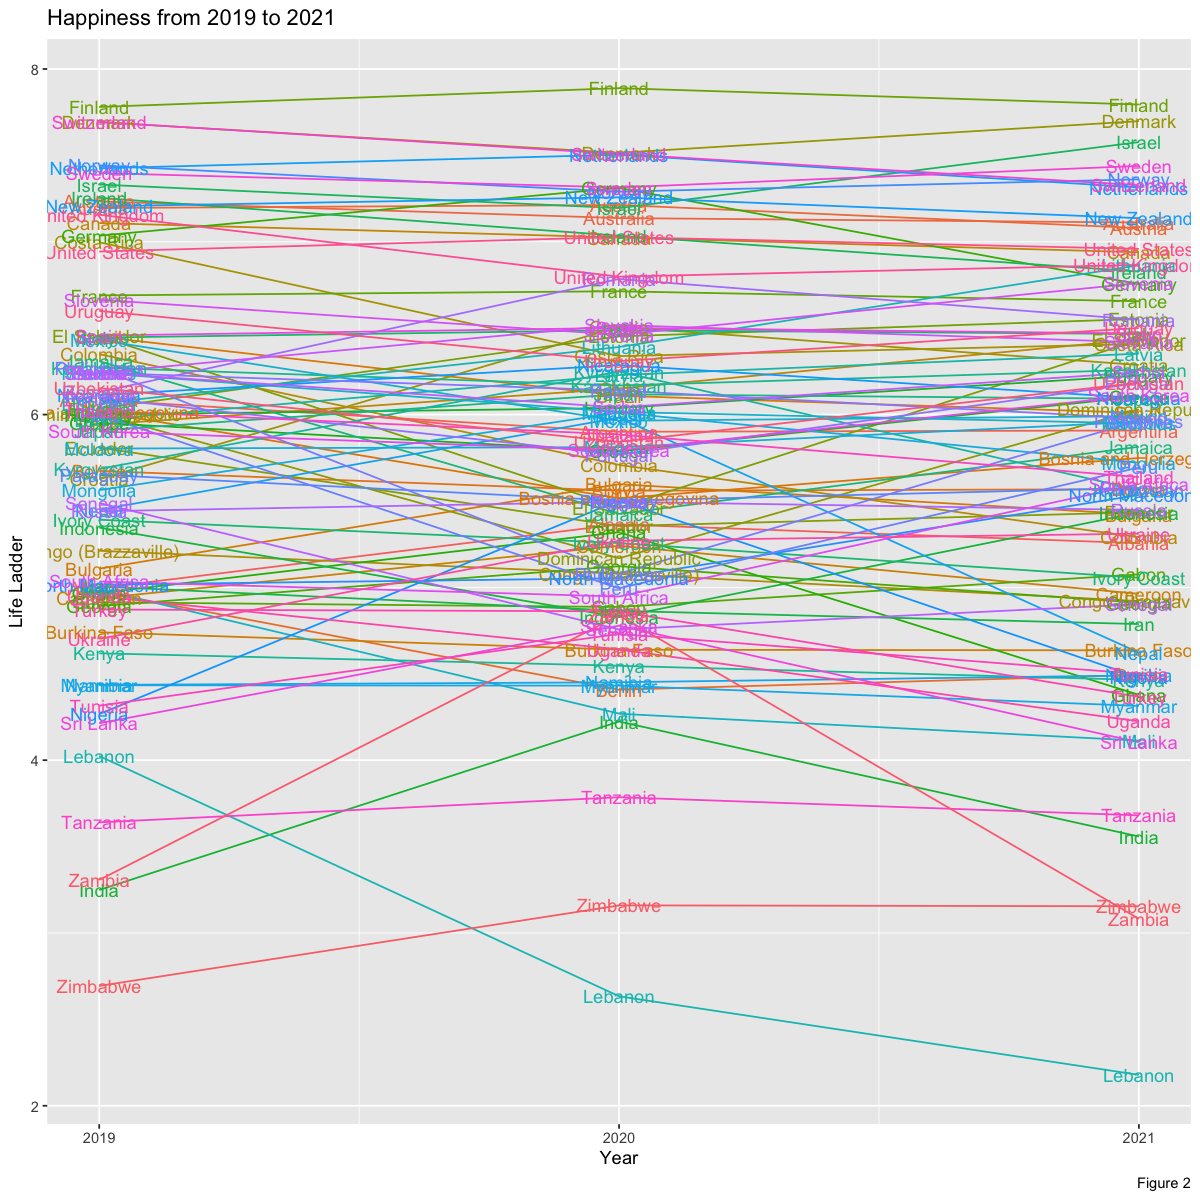

In [12]:
# Change from 2019, 2020, and 2021 happiness
options(repr.plot.width = 10, repr.plot.height = 10)

happiness_trail <- happiness_data_wide_life_ladder |> select(country_name,`2019`,`2020`,`2021`) |> drop_na() |> pivot_longer(cols=-country_name,names_to="year",values_to ="life_ladder") |> mutate(year = as.integer(year)) |>
    ggplot(aes(x=year, y=life_ladder, group=country_name, color=country_name)) +
    geom_line() +
    geom_text(aes(label = country_name)) +
    theme(legend.position="none") +
    labs(x="Year",y="Life Ladder",title="Happiness from 2019 to 2021", caption = "Figure 2") + 
    scale_x_continuous(breaks=c(2019,2020,2021), limits = c(2019,2021))
    
happiness_trail

Figure 2. Changes in happiness score from each country from 2019-2021.

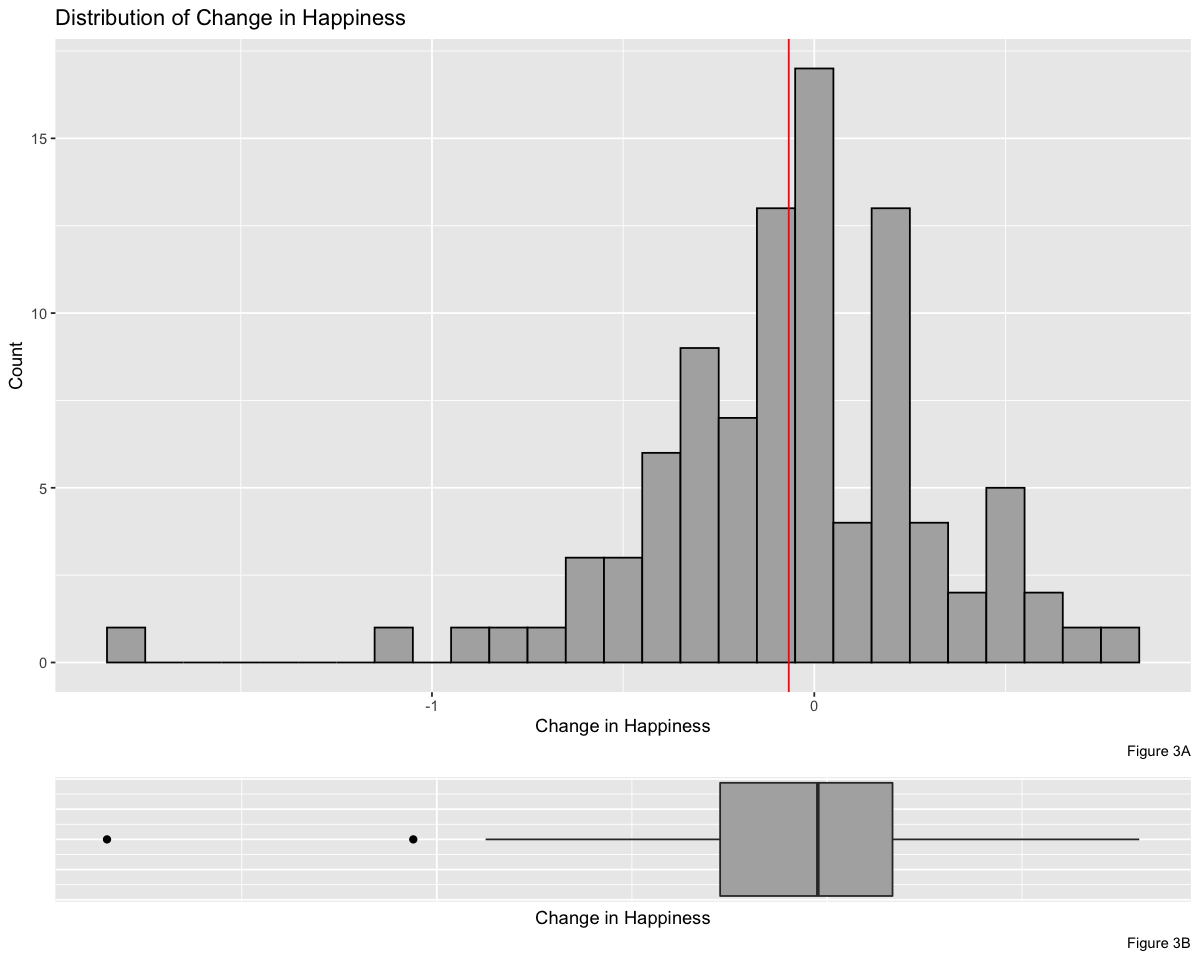

In [13]:
# Change Mean from 2021 to 2019
change_2019_2021 <- happiness_data_wide_life_ladder |>
    select(country_name,`2019`,`2021`) |>
    drop_na() |>
    group_by(country_name) |>
    mutate(change = `2021`-`2019`)

# Mean Change
mean_point_estimate <- mean(change_2019_2021$change)

# Plot the Distribution
options(repr.plot.width = 10, repr.plot.height = 8) 
change_histogram <- change_2019_2021 |>
    ggplot(aes(x=change)) +
    geom_histogram(fill = "grey69", binwidth = 0.1, color="black") +
    geom_vline(xintercept=mean(change_2019_2021$change),color="red") +
    labs(x="Change in Happiness",y="Count",title="Distribution of Change in Happiness", caption = "Figure 3A")

# Plot the Box Plot
change_boxplot <- change_2019_2021 |>
        ggplot(aes(x=change)) +
        geom_boxplot(fill = "grey69", outlier.colour="black", outlier.shape=16,
                 outlier.size=2, notch=FALSE) +
        labs(x="Change in Happiness", caption = "Figure 3B") +
        theme(
            axis.text.y=element_blank(),
            axis.ticks.y=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank())

# Combine the boxplot and histogram together using cowplot
plot_grid(change_histogram, change_boxplot, ncol = 1, rel_heights = c(2, 0.5), align = 'v')

Figure 3. A) Distribution of the changes in happiness score in each country. The red line marks the point estimate of -0.0667 for the mean change in happiness. B) Box plot for the distribution of changes in happiness score in each country. Two data points are indicated as outliers.

### Hypothesis Testing Using Bootstrapping ###

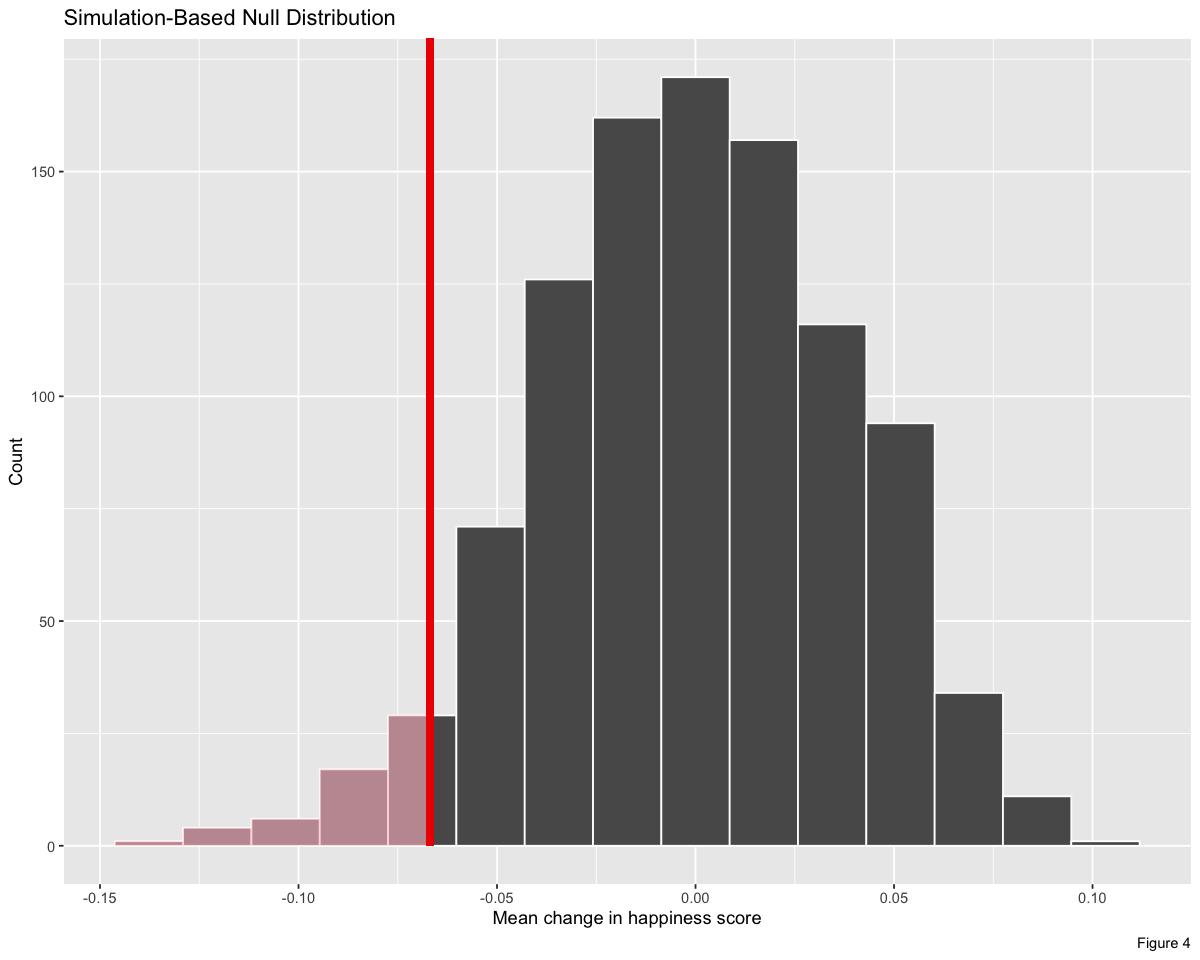

In [14]:
#Set seed for reproducibility
set.seed(201)

#Calculate observed mean change in happiness
obs_mean_change_in_happiness <- 
    mean(change_2019_2021$change)

#Generate null distribution for null mean change of 0
null_dist_change_in_happiness <-
    change_2019_2021 %>%
    specify(response = change)  %>%
    hypothesize(null = "point", mu = 0) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

#Plot the null distribution with the observed mean change in happiness
null_change_in_happiness_plot <- 
    null_dist_change_in_happiness %>% 
    visualize() + 
    shade_p_value(obs_stat = obs_mean_change_in_happiness, direction = 'less') +
    labs(x = "Mean change in happiness score", y = "Count", caption = "Figure 4")
null_change_in_happiness_plot

#Calculate p-value from the null distribution
bootstrap_p_value <- 
    null_dist_change_in_happiness %>% 
    get_p_value(obs_stat = obs_mean_change_in_happiness, direction = "less")

Figure 4. Distribution for the null hypothesis of a mean happiness change of 0. The observed mean change in of -0.0667 is indicated by the red line and has a p value of 0.046. The shaded red region indicates the range of values which show greater decreases in happiness score than the observed.

### Hypothesis Testing Using Asymptotics ###

In [15]:
#Calculate p-value using theory-based methods
theory_p_value <-
    change_2019_2021 %>%
    ungroup() %>%
    summarise(n = n(), mean_diff = mean(change), sd = sd(change), std_error = sd/sqrt(n)) %>%
    mutate(theoretical_p_value = pt(mean_diff/std_error, df = n-1, lower.tail=TRUE))

#Create tibble of observed values
table2 <- 
    tibble(mean_difference = mean(change_2019_2021$change),
           standard_deviation_of_difference = sd(change_2019_2021$change),
           standard_error_of_mean_difference = sd(change_2019_2021$change)/sqrt(nrow(change_2019_2021))) %>%
    bind_cols(bootstrap_p_value = bootstrap_p_value$p_value, theoretical_p_value = theory_p_value$theoretical_p_value)
table2

mean_difference,standard_deviation_of_difference,standard_error_of_mean_difference,bootstrap_p_value,theoretical_p_value
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.06677416,0.3887133,0.03988114,0.046,0.04869506


Table 2. Summary statistics of observed changes in happiness score and p-value for mean difference calculated from bootstrapping and asymptotic methods.

### Confidence Interval ##


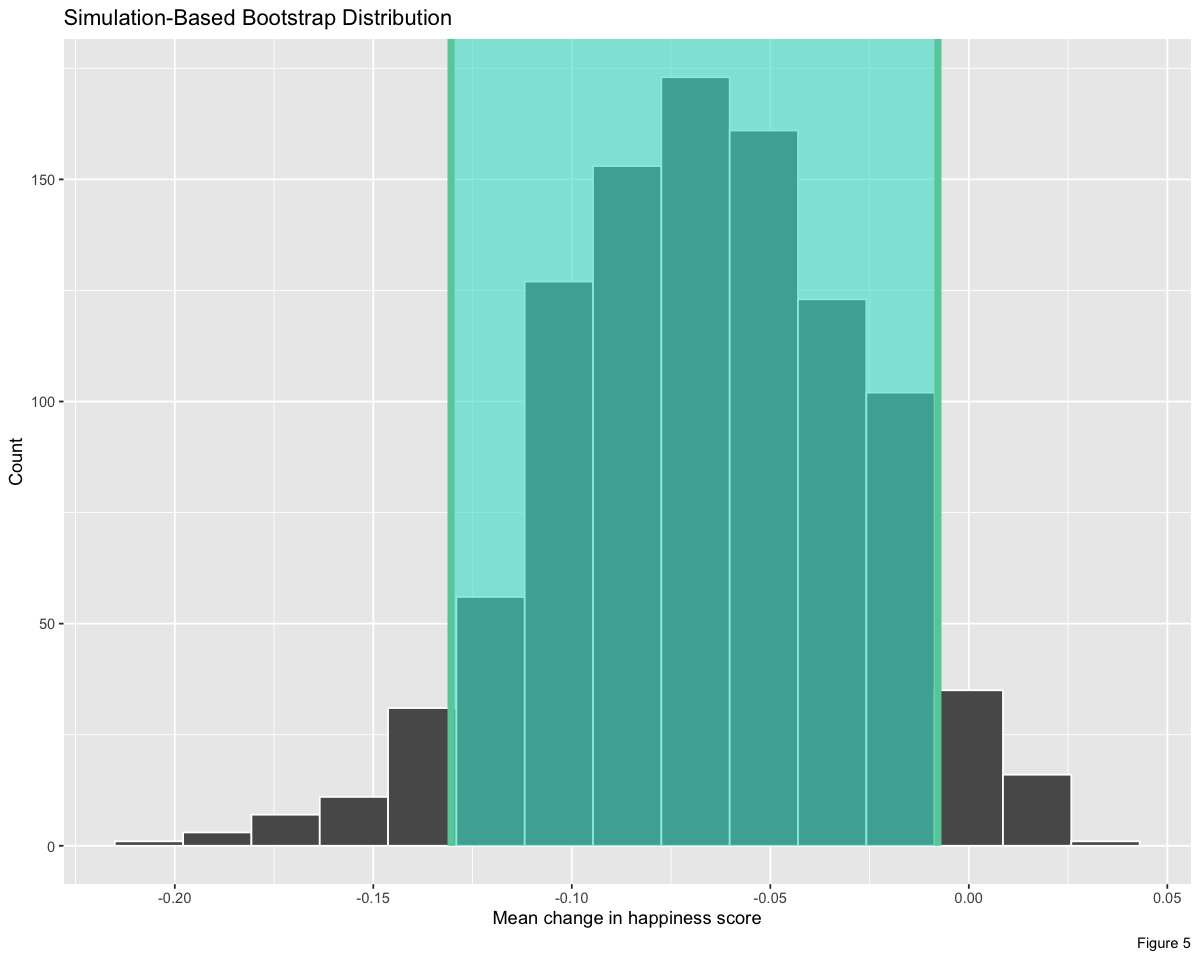

In [16]:
#Set seed for reproducibility
set.seed(201)

#Create bootstrap distribution
change_in_happiness_boot_dist <-
    change_2019_2021 %>%
    specify(response = change)  %>%
    generate(reps = 1000, type = "bootstrap")

#Calculate means from bootstrap distribution
mean_change_in_happiness_boot_dist <-
    change_in_happiness_boot_dist %>%
    calculate(stat = "mean")

#Calculate 95% confidence interval from bootstrap distribution
mean_change_in_happiness_ci <- 
    mean_change_in_happiness_boot_dist %>% 
    summarise(mean_lower_ci = quantile(stat, 0.05), mean_upper_ci = quantile(stat, 0.95))

#Visualize confidence interval on bootstrap distribution
change_in_happiness_boot_plot <- 
    mean_change_in_happiness_boot_dist %>% 
    visualize() + 
    shade_confidence_interval(endpoints = mean_change_in_happiness_ci) +
    labs(x = "Mean change in happiness score", y = "Count", caption = "Figure 5")
change_in_happiness_boot_plot

Figure 5. Bootstrap distribution for mean change in happiness score. The green shaded area indicates the 95% confidence interval.

In [17]:
#Calculate 95% confidence interval for standard deviations from bootstrap distribution
sd_change_in_happiness_boot_dist <-
    change_in_happiness_boot_dist %>%
    calculate(stat = "sd") %>%
    summarise(standard_deviation_lower_ci = quantile(stat, 0.05), standard_deviation__upper_ci = quantile(stat, 0.95))

#Create table for 95% confidence intervals
table3 <- 
    mean_change_in_happiness_ci %>%
    bind_cols(sd_change_in_happiness_boot_dist)
table3

mean_lower_ci,mean_upper_ci,standard_deviation_lower_ci,standard_deviation__upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
-0.1304117,-0.007783775,0.3131963,0.4707453


Table 3. Lower and upper bounds for the 95% confidence intervals for the mean and standard deviation change in happiness score calculated by bootstrapping.

### Summary ###

In [Data Loading, Cleaning, and Splitting](#Data-Loading,-Cleaning,-Splitting) we start by importing the necessary packages. We elected to use janitor package as the raw data was large and contained messy column names. Each row of the data contained an observation for a country by year. Countries had varying level of data availability for a given year so we elected to drop any incomplete observation. For the purpose of data exploration, we split the group to quartiles across different factors and added the corresponding quartile ranking in new columns `<factor>_ntile`. As we are primarily focused on happiness data, we also created a summarized table of countries and the constituents reported level of happiness across the years called `happiness_data_wide_life_ladder`.

In [Preliminary Data Exploration](#Preliminary-Data-Exploration), we created two graphs to show the completeness of the data. `Figure 1A` displays the number of complete observations available by country and categorized by quartiles. In this, we found the number of complete observations were lower for countries in the 4th quartile. `Figure 1B` displays the year over year happiness score to see how much the score varies year over year and the sparsity of consistent data. In this, we found little year over year variability and moderate level of sparsity. 

In [Data Selection](#Data-Selection), we narrowed the data to countries with observations in both 2019, and 2021 as we are focused on pre- and post- COVID-19 level of happiness. We found 95 countries had data in the two years and `Table 1` shows the mean happiness decreased, while variability across countries increased from 2019 and 2021 as measured by each year's standard deviation. `Figure 2` shows that the relative ranking changed moderately in 2019 and 2021. `Figure 3A` and `Figure 3B` show that indeed the mean happiness has decreased but the distribution is very closely centered around 0.

In [Hypothesis Testing Using Bootstrapping](#Hypothesis-Testing-Using-Bootstrapping), we created a null distribution based on the null mean change of 0 and 1000 bootstrapped samples. Based on the bootstrap distribution, we found the p-value of our observed change in mean happiness from 2019 and 2021 to have  p-value of 0.046. The result is presented in `Figure 4`. Similarly, in [Hypothesis Testing Using Asymptotics](#Hypothesis-Testing-Using-Asymptotics), we used paired t-test as the data was collected from subjects before and after an event (2019 and 2021 around COVID-19). Based on `Table 2`, we found the p-value of our observed change in mean to be 0.048. In both tests, the decrease in mean level of happiness is statistically significant at 95% significance level.

The results of both bootstrapping and asymptotic approaches are very close at 0.002 difference. We believe the two are similar because the underlying sample distribution is close to normal distribution as shown in `Figure 1A`.  It also makes sense that the p-value from asymptotic method is slightly larger as it has to account for level of uncertainty and flattens the curve compared to the observed distribution. As a result we believe the two are similarly appropriate and trustworthy in the given context. While asymptotic method still makes assumption around the sample's distribution, the bootstrapping approach is relatively costly in its computation requirement. 

In [Confidence Interval](#Confidence-Interval)'s `Figure 5`, we show the confidence interval based on the bootstrap distribution. The 90% confidence interval does not include 0 implying that we are 90% confident that the confidence interval does not contain 0. `Table 3` also shows the change in standard deviation has increased between 0.31 and 0.47.

## Discussion
___

**The Good**\
Our analysis shows that the majority of countries did not observe a change in happiness greater than 0.5 to -0.5. This report is trustworthy since the data is up-to-date and collected by dedicated and experienced researchers (2).

**The Bad**\
The aforementioned mean change is insufficient because it lacks measures of uncertainty due to variance. Furthermore, by aggregating every country, we lose insights that may be revealed in different groupings like geographical regions. Lastly, we consider 2019 to be "before COVID-19" and 2021 to be "after COVID-19", but this may not be applicable to all countries' situations.

**The Solution**\
To include measures of uncertainty with our point estimate (mean change in happiness), we will perform hypothesis testing for establishing statistical significance of the results and calculate a confidence interval to quantify the errors when estimating the mean change in happiness between 2019 and 2021.

We will perform a paired T-test because the two datasets sample the same countries over an interval of time.

Our hypotheses are:  
$$
\begin{align*}
H_0&: \mu_{\text{2021}} - \mu_{\text{2019}} = 0 \\ 
H_1&: \mu_{\text{2021}} - \mu_{\text{2019}} < 0 \\ 
\end{align*}
$$
* **Null Hypothesis**: There is no change in mean Happiness before and after COVID-19 throughout most countries.
* **Alternative Hypothesis**: The mean happiness decreased after COVID-19 throughout most countries.

The significance level will be 0.05 with a corresponding confidence level of 95% (1- $\alpha$) to reduce the risk of type II errors. We will use the bootstrapping method with set.seed() for reproducibility as this does not require any assumptions about the population distribution (compared to using asymptotic approaches).

**Expected Findings**\
We expect that COVID-19 decreased happiness levels due to the effects of lockdown; studies done on the effects of vitamin D deficiency from lack of sunlight (3) and staying indoors (4) found negative impacts such as depression.

**Impacts**\
Understanding the quantitative impact on happiness could inform future quarantine response procedures. Exploring how certain policies or events affect happiness levels can guide organisations to make better decisions for everyone's happiness (5).

**Future Questions**
* How do different pandemic responses and policies affect happiness levels?
* How does happiness relate to other indicators of success and should it be given greater consideration in policy making? 

## References
___

1. Krys, K., Park, J., Kocimska-Zych, A. et al. (2021). Personal Life Satisfaction as a Measure of Societal Happiness is an Individualistic Presumption: Evidence from Fifty Countries. J Happiness Stud 22, 2197–2214. https://doi.org/10.1007/s10902-020-00311-y

2. Helliwell, J. F., Layard, R., Sachs, J. D., Neve, J.-E. D., Aknin, L. B., & Wang, S. (2021, March 20). World happiness report 2021. https://worldhappiness.report/ed/2021/

3. Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., Anjum, S., Anjum, I., Jaffery, S. S., Fayyaz, M., Samoo, Z., & Anjum, S. (2018). The role of vitamin d in brain health: A mini literature review. Cureus, 10(7). https://doi.org/10.7759/cureus.2960

4. Thakur, K., Kumar, N., & Sharma, N. (2020). Effect of the pandemic and lockdown on mental health of children. The Indian Journal of Pediatrics, 87(7), 552–552. https://doi.org/10.1007/s12098-020-03308-w

5. Musikanski, L. (2014). Happiness in public policy. Journal of Sustainable Social Change, 6(1). https://scholarworks.waldenu.edu/jsc/vol6/iss1/5
